# What if in Python

# Chương 12: Inverse Probability Weighting

## Phần 1: Program 12.1 và 12.2

### BS. Lê Ngọc Khả Nhi


# Giới thiệu

"What if" hay "The Causal Inference book" của Jamie Robins và Miguel Hernan là một tác phẩm rất hay và có thể dùng như một giáo trình về chuyên đề Suy luận nhân quả. 

Phần 1 (10 chương) của sách chủ yếu trình bày về lý thuyết, hầu hết thí dụ là đơn giản và có thể giải quyết bằng tính toán thủ công. Kể từ Chương 11 thì nội dung bắt đầu dùng đến mô hình thống kê như phương tiện để giải quyết các câu hỏi suy luận nhân quả. 

Từ chương 12 trở đi là phần hấp dẫn nhất trong sách vì có khả năng ứng dụng được. Mỗi chương được chia ra thành nhiều phần nhỏ, mỗi phần tương ứng với 1 bài toán, nhưng nội dung chỉ trình bày lý thuyết như cơ chế, công thức chứ không hướng dẫn chi tiết cần phải làm như thế nào trên thực tế. Do đó, người đọc sẽ thấy khó hiểu, dễ chán nản và bỏ cuộc nếu không thực sự bắt tay vào làm thí nghiệm bằng 1 ngôn ngữ tùy chọn (thí dụ R, Stata, SAS, Python) hoặc nhìn thấy script/output minh họa cho mỗi bài toán.

Trong bài này Nhi sử dụng ngôn ngữ Python để minh họa cho Chương 12. Nhi có tham khảo code của James Fiedler https://github.com/jrfiedler/causal_inference_python_code ; với một số thay đổi, thí dụ dùng lập trình hàm thay vì code thủ công và dùng nhiều biểu đồ hơn.

Toàn bộ phần 2 đều dựa trên cùng 1 dataset: National Health and Nutrition Examination Survey (NHEFS).
Các bạn tải dữ liệu từ đây:
https://cdn1.sph.harvard.edu/wp-content/uploads/sites/1268/2017/01/nhefs_excel.zip

Sau khi tải về, các bạn giải nén để có file excel: NHEFS.xls, đặt file này vào cùng thư mục với notebook để làm thí nghiệm.

# Chapter 12

## Program 12.1

### Bối cảnh: 
Khảo sát 1566 người hút thuốc lá tại 2 thời điểm Ban đầu (năm 1971) và Kết thúc (năm 1982). 

Can thiệp là bỏ hút thuốc lá : biến qsmk, giá trị nhị phân 0/1

Kết quả là thay đổi cân năng: wt82_71

Một tập hợp các biến có thể là confounders: 

sex (0: male,1: female), 

age (in years), 

race (0: white, 1: other), 

education (5 categories), 

intensity và duration of smoking (number of cigarettes per day and years of smoking), 

physical activity in daily life (3 categories), 

recreational exercise (3 categories), and weight (in kg).

### Mục tiêu: 

Tái lập kết quả thống kê mô tả trong bảng 12.1

In [1]:
import warnings
warnings.filterwarnings('ignore')

# Dataframe và random

import numpy as np
import pandas as pd

# Stats
import scipy

# Đồ họa
import matplotlib.pyplot as plt
import seaborn as sns

# GLM
from patsy import dmatrices
import statsmodels.formula.api as smf
import statsmodels.api as sm


# RF
from sklearn.ensemble import RandomForestClassifier


# Xem infos
from sinfo import sinfo
sinfo()

-----
matplotlib  3.2.1
numpy       1.18.4
pandas      1.0.3
patsy       0.5.1
scipy       1.4.1
seaborn     0.10.0
sinfo       0.3.1
sklearn     0.22.2.post1
statsmodels 0.11.1
-----
IPython             7.12.0
jupyter_client      5.3.4
jupyter_core        4.6.1
jupyterlab          1.2.6
notebook            6.0.3
-----
Python 3.7.6 (default, Jan  8 2020, 20:23:39) [MSC v.1916 64 bit (AMD64)]
Windows-10-10.0.18362-SP0
8 logical CPU cores, Intel64 Family 6 Model 158 Stepping 9, GenuineIntel
-----
Session information updated at 2020-06-28 17:32


### Chuẩn bị dữ liệu

In [4]:
df = pd.read_excel('NHEFS.xls')

df.head()

WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero


,seqn,qsmk,death,yrdth,modth,dadth,sbp,dbp,sex,age,...,birthcontrol,pregnancies,cholesterol,hightax82,price71,price82,tax71,tax82,price71_82,tax71_82
0,233,0,0,NaN,NaN,NaN,175.0,96.0,0,42,...,2,NaN,197.0,0.0,2.183594,1.739990,1.102295,0.461975,0.443787,0.640381
1,235,0,0,NaN,NaN,NaN,123.0,80.0,0,36,...,2,NaN,301.0,0.0,2.346680,1.797363,1.364990,0.571899,0.549316,0.792969
2,244,0,0,NaN,NaN,NaN,115.0,75.0,1,56,...,0,2.0,157.0,0.0,1.569580,1.513428,0.551270,0.230988,0.056198,0.320251
3,245,0,1,85.0,2.0,14.0,148.0,78.0,0,68,...,2,NaN,174.0,0.0,1.506592,1.451904,0.524902,0.219971,0.054794,0.304993
4,252,0,0,NaN,NaN,NaN,118.0,77.0,0,40,...,2,NaN,216.0,0.0,2.346680,1.797363,1.364990,0.571899,0.549316,0.792969


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1629 entries, 0 to 1628
Data columns (total 64 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   seqn               1629 non-null   int64  
 1   qsmk               1629 non-null   int64  
 2   death              1629 non-null   int64  
 3   yrdth              318 non-null    float64
 4   modth              322 non-null    float64
 5   dadth              322 non-null    float64
 6   sbp                1552 non-null   float64
 7   dbp                1548 non-null   float64
 8   sex                1629 non-null   int64  
 9   age                1629 non-null   int64  
 10  race               1629 non-null   int64  
 11  income             1567 non-null   float64
 12  marital            1629 non-null   int64  
 13  school             1629 non-null   int64  
 14  education          1629 non-null   int64  
 15  ht                 1629 non-null   float64
 16  wt71               1629 

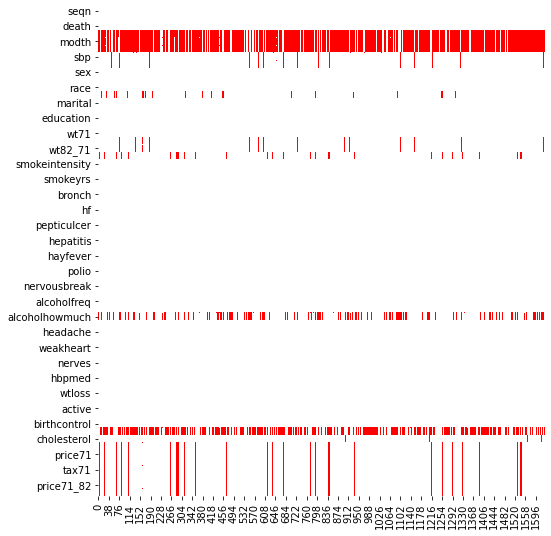

In [6]:
plt.figure(figsize=(8,9))

sns.heatmap(df.T.isnull(), 
            cmap=['white','red'], cbar=False)

Chỉ giữ lại những cases có đủ dữ liệu cho 8 biến sau:

In [7]:
check_cols = ['sex', 'age', 'race', 'wt82', 
             'ht', 'school', 'alcoholpy', 
             'smokeintensity']

na_mask = df[check_cols].isna().any(axis=1)

df_1 = df.loc[~na_mask]

df_1.shape

(1566, 64)

### Thực hiện 

Tạo 3 biến mới là University, Inactive và No exercice

In [9]:
def quick_dummy(ar, val = None):
    return (ar == val).astype('int')

df_1['university'] = quick_dummy(df_1.education, 5)
df_1['inactive'] = quick_dummy(df_1.active, 2)
df_1['no_exercise'] = quick_dummy(df_1.exercise, 2)

Chuẩn bị hàm quick_sum cho phép tính trung bình cho biến định lượng liên tục và tỉ lệ % của bậc giá trị Yes (=1) cho biến nhị phân, sau đó dùng group_by, aggregate và hàm quick_sum này để có nội dung kết quả như trong bảng 12.1

In [12]:
def quick_sum(k):
    if len(df_1[k].unique()) == 2:
        return lambda x: 100 * (x==1).mean()
    else:
        return lambda x: x.mean()
    
func_dict = {k:quick_sum(k) for k in ['age','sex',
                                      'race','university',
                                      'wt71','smokeintensity',
                                     'smokeyrs','no_exercise','inactive',]}

table = df_1.groupby('qsmk').agg(func_dict)
table['sex'] = 100-table['sex'] # Ta cần tỉ lệ nam giới

table.T

qsmk,0,1
age,42.788478,46.173697
sex,46.603611,54.590571
race,14.617369,8.933002
university,9.888220,15.384615
wt71,70.302837,72.354888
smokeintensity,21.191745,18.602978
smokeyrs,24.087704,26.032258
no_exercise,37.919175,40.694789
inactive,8.942390,11.166253


## Program 12.2

### Bối cảnh

Tác giả giới thiệu phương pháp Inverse probability weighting (IPW)

Các bạn đọc nội dung trang 151 để hiểu rõ về cơ chế của IPW, cũng có thể tham khảo :

https://en.wikipedia.org/wiki/Inverse_probability_weighting
http://www.rebeccabarter.com/blog/2017-07-05-ip-weighting/

### Mục tiêu

Tạo ra array IP weight cho 1566 quan sát, có giá trị giống tái lập lại kết quả trong sách "The estimated IP weights ranged from 1.05 to 16.7, and their mean was 2.00"

### Thực hiện thí nghiệm

Trước hết, ta quay trở lại câu hỏi nghiên cứu: Liệu bỏ hút thuốc có phải là nguyên nhân của thay dổi về cân nặng hay không ?

Cách làm "ngây thơ" thường như sau:

In [13]:
df_1.groupby('qsmk').wt82_71.describe(percentiles = [0.05,0.5,0.95])

,count,mean,std,min,5%,50%,95%,max
qsmk,,,,,,,,
0,1163.0,1.984498,7.449076,-41.28047,-10.089160,2.151084,12.798718,48.538386
1,403.0,4.525079,8.748261,-22.23047,-8.378576,3.971582,19.334903,47.511303


Hoặc bằng mô hình tuyến tính xét trực tiếp qsmk như biến độc lập:

In [14]:
mod1 = smf.glm("wt82_71 ~ qsmk", df).fit()

mod1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                wt82_71   No. Observations:                 1566
Model:                            GLM   Df Residuals:                     1564
Model Family:                Gaussian   Df Model:                            1
Link Function:               identity   Scale:                          60.898
Method:                          IRLS   Log-Likelihood:                -5438.6
Date:                Sun, 28 Jun 2020   Deviance:                       95244.
Time:                        18:03:59   Pearson chi2:                 9.52e+04
No. Iterations:                     3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.9845      0.229      8.672      0.000       1.536       2.433
qsmk           2.5406      0.451      5.632      0.000       1.656       3.425
==============================================================================
"""

Tuy nhiên như đã bàn, ít nhất 9 yếu tố có khả năng là confounders trong bài toán này, kết quả thống kê mô tả ở trên cũng cho ta thấy có sự khác biệt về phân bố của các confounders giả định này giữa 2 phân nhóm qsmk = 1 hay =0.

Ta hy vọng là phương pháp IP weight có thể tạo ra một dữ liệu mô phỏng (giả), cho phép triệt tiêu những hiệu ứng gây nhiễu lên treatment (qsmk), từ đó ước tính chính xác hơn hiệu ứng can thiệp.

Program 12.2 trình bày giải pháp đơn giản nhất để làm IPW: 

1) Trước hết ta chuẩn bị 1 hàm tính propensity score, là xác suất bỏ hút thuốc (can thiệp=1), tùy theo giá trị của counfounders, ta có thể dùng 1 binary classifier

2) Tính mẫu số d của IP Weight: d = propensity nếu qsmk = 1 và d = (1 - propensity) nếu qsmk = 0

3) IP weight được xác định = 1/d

4) Dùng mô hình Weighted LS với vector IP weight để ước tính treatment effect

Ghi chú: tác giả đề xuất dùng hàm bậc 2 cho các confounders định lượng như age, wt71, smokeintensity và smokeyrs, ta có thể kiểm chứng lại giả định này như sau:

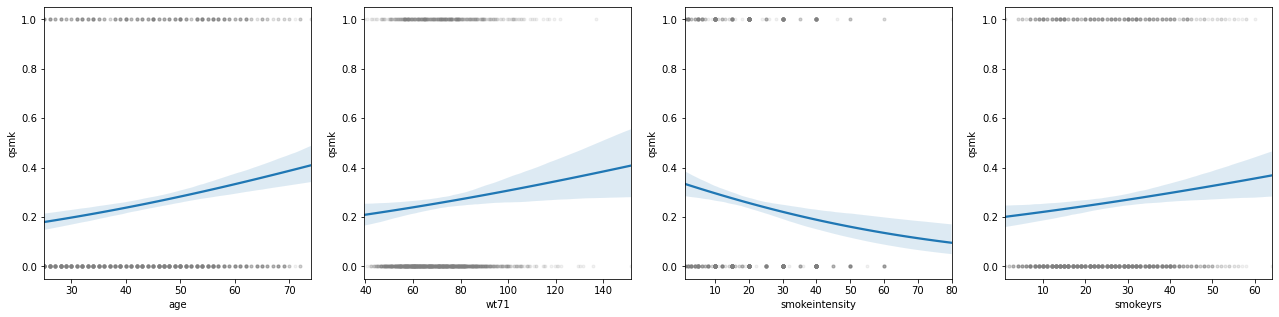

In [16]:
quant_confounders = ['age', 'wt71', 'smokeintensity', 'smokeyrs']

fig, axs = plt.subplots(ncols=len(quant_confounders), figsize=(22,5))

for i,v in enumerate(quant_confounders):
    g = sns.regplot(x = v, 
                    y = 'qsmk',
                    data = df_1,
                    logistic = True,
                    marker = ".",
                    scatter_kws={'alpha':0.1, 'color':'grey'},
                    ax = axs[i])

Như vậy Nhi sẽ đưa thêm giá trị bậc 2 cho các biến trên vào design matrix,
Ngoài ra, ta tạo các dummy variables cho các confounders nhị phân hay nhiều giá trị:

In [18]:
for col in ['age', 'wt71', 'smokeintensity', 'smokeyrs']:
    df_1[f'{col}_2'] = df_1[col] ** 2
    
df2 = pd.concat([df_1] + [pd.get_dummies(df_1[col], prefix = col[:3])
                 for col in ['education','exercise','active']],
                axis = 1)

df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1566 entries, 0 to 1628
Data columns (total 82 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   seqn               1566 non-null   int64  
 1   qsmk               1566 non-null   int64  
 2   death              1566 non-null   int64  
 3   yrdth              291 non-null    float64
 4   modth              295 non-null    float64
 5   dadth              295 non-null    float64
 6   sbp                1537 non-null   float64
 7   dbp                1533 non-null   float64
 8   sex                1566 non-null   int64  
 9   age                1566 non-null   int64  
 10  race               1566 non-null   int64  
 11  income             1507 non-null   float64
 12  marital            1566 non-null   int64  
 13  school             1566 non-null   int64  
 14  education          1566 non-null   int64  
 15  ht                 1566 non-null   float64
 16  wt71               1566 

Sau đó Nhi dùng method patsy.dmatrices để chuẩn bị array y,X để ước tính propensity score

Bài toán ước tính propensity score có bản chất là 1 mô hình phân loại có outcome y = xác suất nhận giá trị treatment = 1 (ở đây là qsmk), dựa vào design matrix X, 

Trong sách, tác giả dùng mô hình hồi quy logistic, tuy nhiên bạn có thể dùng bất cứ classifier nào khác, thí dụ Random Forest hay XGBoost...

In [19]:
form = 'qsmk ~ 1 + sex + race + \
age + age_2 + \
edu_2 + edu_3 + edu_4 + edu_5 + \
smokeintensity + smokeintensity_2 + \
smokeyrs + smokeyrs_2 + \
exercise + exe_1 + exe_2 + \
act_1 + act_2 + \
wt71 + wt71_2'

from patsy import dmatrices

y,X = dmatrices(form,  
                data=df2,
                return_type='dataframe')

In [20]:
y

,qsmk
0,0.0
1,0.0
2,0.0
3,0.0
4,0.0
...,...
1623,0.0
1624,0.0
1625,0.0
1627,0.0


In [21]:
X

,Intercept,sex,race,age,age_2,edu_2,edu_3,edu_4,edu_5,smokeintensity,smokeintensity_2,smokeyrs,smokeyrs_2,exercise,exe_1,exe_2,act_1,act_2,wt71,wt71_2
0,1.0,0.0,1.0,42.0,1764.0,0.0,0.0,0.0,0.0,30.0,900.0,29.0,841.0,2.0,0.0,1.0,0.0,0.0,79.04,6247.3216
1,1.0,0.0,0.0,36.0,1296.0,1.0,0.0,0.0,0.0,20.0,400.0,24.0,576.0,0.0,0.0,0.0,0.0,0.0,58.63,3437.4769
2,1.0,1.0,1.0,56.0,3136.0,1.0,0.0,0.0,0.0,20.0,400.0,26.0,676.0,2.0,0.0,1.0,0.0,0.0,56.81,3227.3761
3,1.0,0.0,1.0,68.0,4624.0,0.0,0.0,0.0,0.0,3.0,9.0,53.0,2809.0,2.0,0.0,1.0,1.0,0.0,59.42,3530.7364
4,1.0,0.0,0.0,40.0,1600.0,1.0,0.0,0.0,0.0,20.0,400.0,19.0,361.0,1.0,1.0,0.0,1.0,0.0,87.09,7584.6681
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1623,1.0,1.0,0.0,47.0,2209.0,0.0,0.0,0.0,0.0,20.0,400.0,31.0,961.0,0.0,0.0,0.0,0.0,0.0,84.94,7214.8036
1624,1.0,0.0,0.0,45.0,2025.0,0.0,0.0,0.0,0.0,40.0,1600.0,29.0,841.0,0.0,0.0,0.0,0.0,0.0,63.05,3975.3025
1625,1.0,1.0,0.0,47.0,2209.0,0.0,0.0,0.0,0.0,20.0,400.0,31.0,961.0,0.0,0.0,0.0,0.0,0.0,57.72,3331.5984
1627,1.0,0.0,0.0,68.0,4624.0,0.0,0.0,0.0,0.0,15.0,225.0,46.0,2116.0,1.0,1.0,0.0,1.0,0.0,52.39,2744.7121


### Tính IPW bằng hồi quy Logistic 

In [22]:
def propensity(y, X):
    """
    Tính propensity score hay f(y|X)
    sừ dụng hồi quy logistic
    
    Parameters
    ----------
    y : Pandas Series
    X : Pandas DataFrame
    
    Returns
    -------
    propensity score: Numpy array
    """
    y = np.asarray(y).flatten()
    mod = sm.Logit(y, X).fit()
    weights = np.zeros(X.shape[0])
    weights[y == 1] = mod.predict(X.loc[y == 1])
    weights[y == 0] = (1 - mod.predict(X.loc[y == 0]))
    return weights

def ip_weight(y, X):
    return 1/propensity(y, X)

In [23]:
weights = ip_weight(y, X)

Optimization terminated successfully.
         Current function value: 0.535408
         Iterations 6


In [24]:
weights

array([1.10953014, 1.16323318, 1.14367927, ..., 1.14638591, 1.68591964,
       5.82552577])

### Tính IPW bằng Random Forest classifier

Như đã nói ở trên, Nhi có thể thử dùng 1 mô hình Random Forest để tính IPW:

In [25]:
def propensity_rf(y, X):
    """
    Tính propensity score hay f(y|X)
    sừ dụng random forest classifier
    
    Parameters
    ----------
    y : Pandas Series
    X : Pandas DataFrame
    
    Returns
    -------
    propensity score: Numpy array
    """
    y = np.asarray(y).flatten()
    clf = RandomForestClassifier(n_estimators = 500,
                                 max_depth=3, 
                                 random_state=0)
    clf.fit(X,y)
    weights = np.zeros(X.shape[0])
    weights[y == 1] =  clf.predict_proba(X.loc[y == 1])[:,1]
    weights[y == 0] = (1 - clf.predict_proba(X.loc[y == 0])[:,1])
    return weights

In [26]:
weights_rf = 1/propensity_rf(y, X)

weights_rf

array([1.27105576, 1.2491694 , 1.30739119, ..., 1.25638332, 1.42118727,
       4.5431102 ])

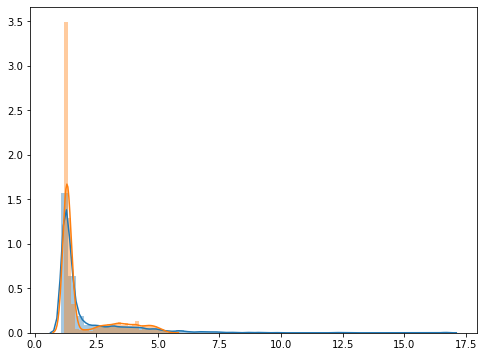

In [29]:
fig, ax = plt.subplots(figsize=(8, 6))

sns.distplot(weights)
sns.distplot(weights_rf)

In [30]:
pd.DataFrame({'Logistic': weights,
             'RF': weights_rf}).describe()

,Logistic,RF
count,1566.000000,1566.000000
mean,1.996284,1.933425
std,1.474787,1.111959
min,1.053742,1.206100
25%,1.229623,1.272944
50%,1.373169,1.348921
75%,1.989869,2.123041
max,16.700094,5.376352


Như vậy kết quả thống kê của IPW tính bằng logistic hoàn toàn giống trong sách: Mean = 2, min = 1.05, max = 16.7;
Kết quả IPW tính bằng RF cũng tương tự nhưng ít phân tán hơn

# Tính treatment effect bằng Weighted LS

Sau khi đã tính được vector IPW cho 1566 quan sát, ta dùng WLS để dựng mô hình wt82_71 ~ intercept + qsmk

In [45]:
form = "wt82_71 ~ qsmk"

y,X = dmatrices(form, 
                data=df2,
               return_type='dataframe')

In [44]:
X

,Intercept,qsmk
0,1.0,0.0
1,1.0,0.0
2,1.0,0.0
3,1.0,0.0
4,1.0,0.0
...,...,...
1623,1.0,0.0
1624,1.0,0.0
1625,1.0,0.0
1627,1.0,0.0


In [46]:
y

,wt82_71
0,-10.093960
1,2.604970
2,9.414486
3,4.990117
4,4.989251
...,...
1623,8.500028
1624,1.360117
1625,3.514970
1627,4.762639


In [51]:
wls = sm.WLS(y, X, 
             weights=weights,
            groups = df2.seqn).fit()

wls.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:                wt82_71   R-squared:                       0.044
Model:                            WLS   Adj. R-squared:                  0.043
Method:                 Least Squares   F-statistic:                     71.14
Date:                Sun, 28 Jun 2020   Prob (F-statistic):           7.47e-17
Time:                        18:38:24   Log-Likelihood:                -5613.4
No. Observations:                1566   AIC:                         1.123e+04
Df Residuals:                    1564   BIC:                         1.124e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.7800      0.288      6.175      0.000       1.215       2.345
qsmk           3.4405      0.408      8.434      0.000       2.640       4.241
==============================================================================
Omnibus:                      209.380   Durbin-Watson:                   2.071
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1901.746
Skew:                           0.281   Prob(JB):                         0.00
Kurtosis:                       8.369   Cond. No.                         2.62
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Kết quả này giống với trong sách, theo đó giá trị ước tính $\theta1$ = 3.4, tuy nhiên 95%CI có khác biệt 1 chút là 2.64 đến 4.24 thay vì 2.4 đến 4.5; tuy nhiên sự khác biệt này không đáng kể.

Nếu dùng IPW tính bằng Random Forest:

In [50]:
wls_rf = sm.WLS(y, X, 
                weights=weights_rf,
               groups = df2.seqn).fit()

wls_rf.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:                wt82_71   R-squared:                       0.039
Model:                            WLS   Adj. R-squared:                  0.038
Method:                 Least Squares   F-statistic:                     62.67
Date:                Sun, 28 Jun 2020   Prob (F-statistic):           4.59e-15
Time:                        18:38:18   Log-Likelihood:                -5587.1
No. Observations:                1566   AIC:                         1.118e+04
Df Residuals:                    1564   BIC:                         1.119e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.8550      0.285      6.500      0.000       1.295       2.415
qsmk           3.2319      0.408      7.917      0.000       2.431       4.033
==============================================================================
Omnibus:                      219.093   Durbin-Watson:                   2.052
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1831.812
Skew:                           0.365   Prob(JB):                         0.00
Kurtosis:                       8.248   Cond. No.                         2.59
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Có khác biệt không đáng kể giữa Logistic và RF về 95%CI của treatment effect

Nhi tạm dừng phần 1 ở đây, trong phần 2 ta sẽ tiếp tục thực hiện các phương pháp Inverse probability weighting phức tạp hơn.